# Notebook for looking at photon yield / percentage for diff theta, phi

In [2]:
#imports
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
from scipy.optimize import curve_fit
import sympy
from IPython.display import clear_output
import math
import time
import util
#My imports
from util import PVect,get_layer,create_layer_map,theta_func,phi_func,findBin,bin_percent_theta_phi

Using device cpu


In [58]:
n_files = 20

In [59]:
layer_map,super_layer_map = create_layer_map()
n_bins = 20

theta_min = 0.1745
theta_max = 2.966500

theta_range = theta_max - theta_min

theta_bins = np.linspace(theta_min,theta_max,n_bins)
theta_bins_deg = theta_bins * 180 / 3.1415926535

In [60]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}

In [68]:
%%capture
histo_fig, histo_axs = plot.subplots(5,4, figsize = (20,25));
histo_fig.suptitle("Histogram of # of photons");

In [69]:
time_diff_means = np.empty(n_files)

In [71]:
for curr_bin in range(n_files):
    uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_24/variation_pos/mu/varied_theta_same_pos_{curr_bin}.edm4hep.root:events"
    with up.open(uproot_path) as events:
        x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
        z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
        EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
        Pathlength_branch = events["HcalBarrelHits.pathLength"].array(library='np')
        Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
        PDG_branch = events["MCParticles.PDG"].array(library='np')

        time_branch = events["HcalBarrelHits.time"].array(library='np')   

        MC_px = events["MCParticles.momentum.x"].array(library='np')
        MC_py = events["MCParticles.momentum.y"].array(library='np')
        MC_pz = events["MCParticles.momentum.z"].array(library='np')
        MC_m = events["MCParticles.mass"].array(library='np')
        MC_vertex_x = events["MCParticles.vertex.x"].array(library='np')
        MC_vertex_z = events["MCParticles.vertex.z"].array(library='np')
        MC_time_branch = events["MCParticles.time"].array(library='np')
        curr_theta = theta_bins[curr_bin]
        
        #histogram
        row = curr_bin // 4
        col = curr_bin % 4
        num_photons = np.empty(len(PDG_branch))
        for event_idx in range(len(PDG_branch)):
            num_photons[event_idx] = np.asarray(np.where(PDG_branch[event_idx] == -22, 1, 0)).sum()
        histo_axs[row, col].hist(num_photons / 1000,bins = 100);
        histo_axs[row,col].set_title(f"theta = {theta_bins_deg[curr_bin]}")
        histo_axs[row,col].set_xlabel("# of photons (thousands)")
        histo_axs[row,col].set_ylabel("Counts (# events)")
        
        #time diff
        time_diff = []

        break_val = 2000
        for event_idx in range(len(time_branch)):
            num_photons = 0
            if(not (event_idx % (break_val // 100))):
                clear_output(wait = True)
                print(f"{event_idx // (break_val // 100)}% done")
            if(event_idx > break_val):
                break
            for hit in range(len(time_branch[event_idx])):
                #check if hit is from optph
                if(PDG_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] != -22):
                    continue
                hit_time = time_branch[event_idx][hit]
                emission_time = MC_time_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] 
                time_diff.append(hit_time - emission_time)
        time_diff_means[curr_bin] = sum(time_diff) / len(time_diff)

99% done


In [72]:
histo_fig.savefig("plots/time_parameterization/theta_vary/num_photons_histo_20.jpeg")
histo_fig.show()

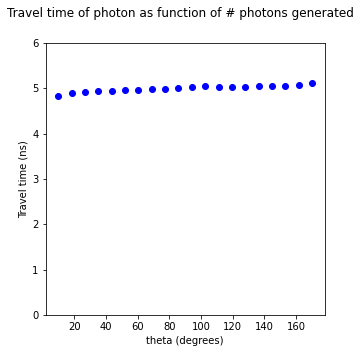

In [75]:
fig, ax1 = plot.subplots(1,1, figsize=(5,5))
fig.suptitle("Travel time of photon as function of # photons generated")
ax1.set_ylabel("Travel time (ns)")
ax1.scatter(theta_bins_deg,time_diff_means,color = "blue")
ax1.set_xlabel("theta (degrees)")
ax1.set_ylim(0,6)
fig.show()
fig.savefig("plots/time_parameterization/theta_vary/photon_travel_time_20.jpeg")

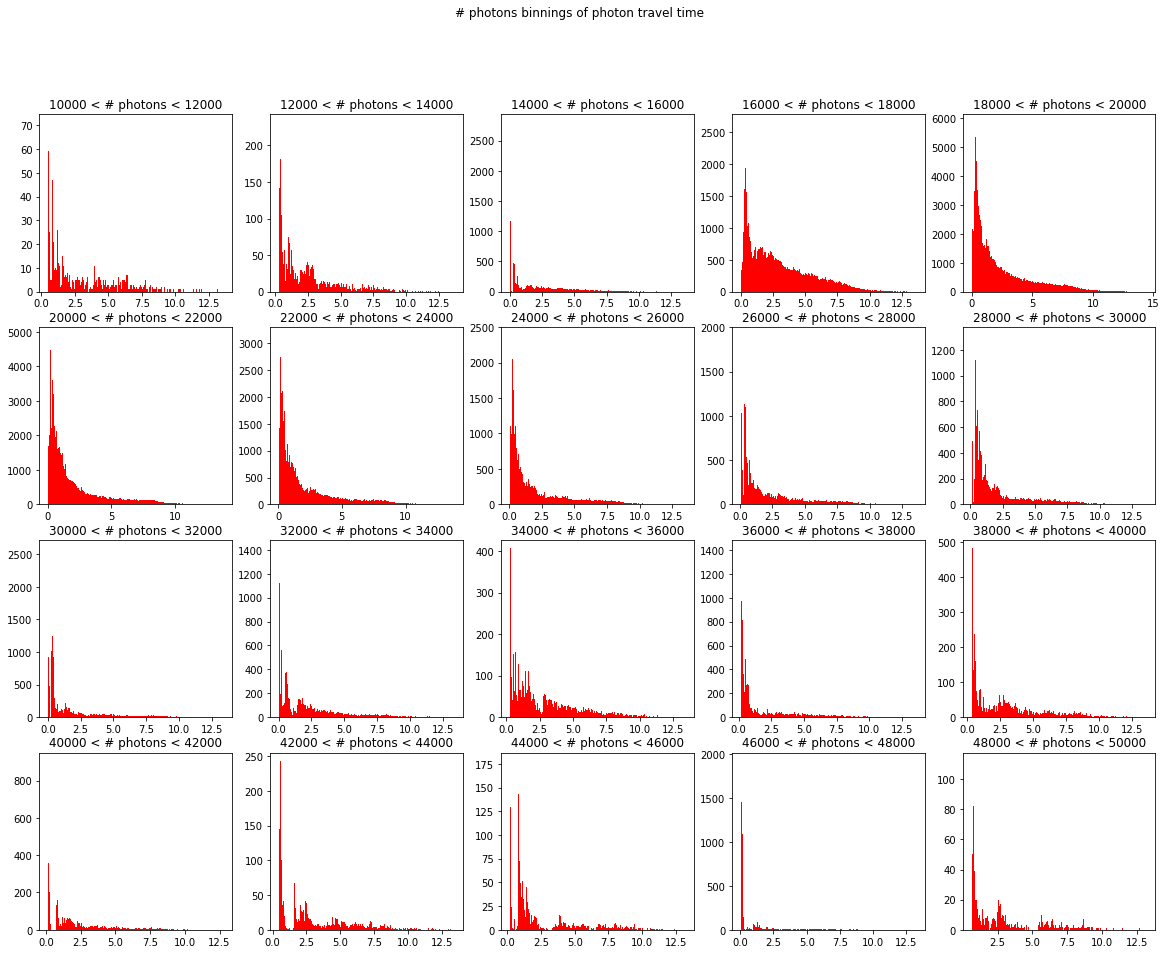

In [153]:
fig, axs = plot.subplots(4,5,figsize = (20,15))
fig.suptitle("# photons binnings of photon travel time")
for i in range(axs.shape[0]):
    n_columns = axs.shape[1]
    for j in range(n_columns):
        axs[i,j].set_title("%4.0f < # photons < %4.0f"%(np_bins[i * 5 + j],np_bins[i * 5 + j + 1]))
        axs[i,j].hist(time_diff[i * 5 + j], color = 'r', bins = 1000)
fig.savefig("plots/time_parameterization/theta_vary/histos_travel_time_theta.jpeg")